In [1]:
import numpy as np
import pandas as pd
#for Kmeans clustering
from sklearn import cluster
from sklearn.cluster import KMeans
from datetime import datetime
from datetime import date
#for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
#for word embedding
#"conda install -c conda-forge genism" or pip install genism
import gensim
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

# from adjustText import adjust_text
#for dimensionality reduction of the extracted features
# from sklearn.manifold import TSNE
# for minibatch kmenas clustering
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.metrics import silhouette_samples, silhouette_score
# from sklearn.decomposition import PCA
#to find number of days between created and updated project repos

In [2]:
#reading project metadata from github projects
df = pd.read_csv("GitHub_Projects.csv")
#getting number of days the project been created and last updated
updated = pd.to_datetime(df["updated_at"]).dt.date
created = pd.to_datetime(df["created_at"]).dt.date
days = updated-created
days = pd.to_numeric(days.dt.days, downcast='integer')
df["updated-created"] = days 
df["desc_word_count"] = df["Description"].apply(lambda x: len(str(x).split()))


In [3]:
#data = df[["repo_name", "Description", "stargazers_count", "forks_count", "num_model_file", "updated-created"]]
#data.head()
# data.to_csv("numerical_cluster.csv")

In [4]:
data1 = df[["stargazers_count", "forks_count", "num_model_file", "updated-created", "desc_word_count"]]
data1.head()

,stargazers_count,forks_count,num_model_file,updated-created,desc_word_count
0,0,7,3,2459,11
1,4,18,22,3085,9
2,7,5,11,2684,7
3,1,0,1,545,6
4,27,17,2,2415,29


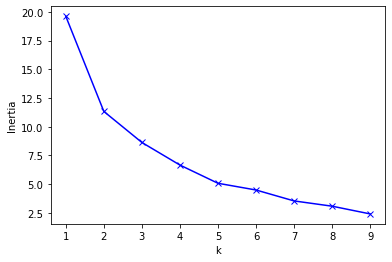

In [5]:
#inspired from https://www.kaggle.com/ellecf/visualizing-multidimensional-clusters
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(data1)
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [6]:
#from the above elbow method we got the number of clusters to be 2 as the elbow is forming at k=2
kmeans = KMeans(n_clusters=2).fit(features_normal)
labels = pd.DataFrame(kmeans.labels_)
df["numeric_cluster"] = labels


In [7]:
# onlynumericclusters = pd.concat((data1, labels),axis=1)
# onlynumericclusters = onlynumericclusters.rename({0:'labels'},axis=1)
# onlynumericclusters.head()
# df_num_cluster = df.groupby(df.numeric_cluster)
# df_num_cluster0 = df_num_cluster.get_group(0)
# df_num_cluster1 = df_num_cluster.get_group(1)
# df_num_cluster0.to_csv("github_num_cluster_academic.csv")
# df_num_cluster1.to_csv("github_num_cluster_industrial.csv")
# df_num_cluster1.describe()
# df_num_cluster0.describe()

In [8]:
#trying to visualize how projects have been distributed in regards to the selected numeric features in the data.
#sns.pairplot(onlynumericclusters,hue='labels')

In [9]:
#reading project metadata from github projects
df_matlab = pd.read_csv("MATC_Projects.csv")
df_matlab["content_word_count"] = df_matlab["content"].apply(lambda x: len(str(x).split()))
data_matlab = df_matlab[["no_of_comments", "no_of_ratings", "num_model_file", "content_word_count", "downloads"]]
data_matlab.head()

,no_of_comments,no_of_ratings,num_model_file,content_word_count,downloads
0,18,46,1,46,3
1,3,4,15,91,1
2,1,2,2,94,2
3,21,22,2,59,12
4,11,27,2,52,2


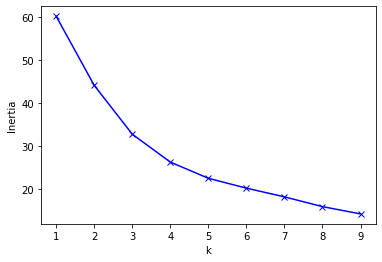

In [10]:
scaler_matlab = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(data_matlab)
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [11]:
#inspired from https://www.kaggle.com/ellecf/visualizing-multidimensional-clusters
scaler_matlab = preprocessing.MinMaxScaler()
features_normal_matlab = scaler_matlab.fit_transform(data_matlab)
kmeans_matlab = KMeans(n_clusters=2).fit(features_normal_matlab)
labels_matlab = pd.DataFrame(kmeans_matlab.labels_)
df_matlab["numeric_clusters"] = labels_matlab


In [12]:
# matlabnumericclusters = pd.concat((data_matlab, labels_matlab),axis=1)
# matlabnumericclusters = matlabnumericclusters.rename({0:'labels_matlab'},axis=1)
# matlabnumericclusters.head()
# df_num_cluster_matlab = df_matlab.groupby(df_matlab.numeric_cluster)
# df_num_cluster_matlab0 = df_num_cluster_matlab.get_group(0)
# df_num_cluster_matlab1 = df_num_cluster_matlab.get_group(1)
# df_num_cluster_matlab0.to_csv("matlab_num_cluster_0.csv")
# df_num_cluster_matlab1.to_csv("matlab_num_cluster_1.csv")
#sns.pairplot(matlabnumericclusters,hue='labels_matlab')

In [13]:
#Text preprocessing code 
#references: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
#references: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
def preprocess(text):
    text = text.lower() 
    text=text.strip()
    text = text.replace(',', '')
    text = text.replace(u'\ufffd', '8')
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)
    text = re.sub('\W_',' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub('\W_',' ', text)        
    text = re.sub("\S*\d\S*"," ", text)   
    text = re.sub("\S*@\S*\s?"," ", text) 
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'www\S+', '', text)
    return text
# fixing word length for correcting the overspelt words
# reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
def reduce_lengthening(text):
    if text.isalpha() and 'simul' not in text:
        pattern = re.compile(r"(.)\1{2,}")
        correct =  pattern.sub(r"\1\1", text)
        return correct
    else:
        return ''

# STOPWORD REMOVAL
def stopword(string):
    stopwords = nltk.corpus.stopwords.words('english')
#     print(len(stopwords))
    newStopWords = ['simulink','matlab', 'control', 'design', 'analysis', 'example', 'repository', 'full', 'plant', 'owner',
    'project', 'implement', 'program', 'code', 'library', 'interface', 'tool', 'toolbox', 'modeling', 'indranil', 'toolkit',
    'function', 'script', 'simple', 'template', 'methiod', 'block', 'demo', 'simulate', 'tutorial', 'width','como', 'ejemplo',
    'show', 'simulator', 'real', 'open', 'source', 'system', 'software', 'model', 'time', 'environment', 'servo', 'framework',
    'input', 'output', 'file', 'value', 'controller', 'ccntrol', 'matrix', 'unzip', 'folder', 'blockset', 'filter', 'stateflow',
    'algorithm', 'folder', 'principal', 'parameter', 'effect', 'convert', 'viterbi', 'workshop', 'state', 'space',
    'right', 'counter', 'method', 'select', 'parallel', 'status', 'number', 'builder', 'limit', 'pattern', 'webinar',
    'index', 'problem', 'minimum', 'johnson', 'karachi', 'kalman', 'color', 'paper', 'result', 'subsystem', 'mosfet',
    'level', 'version', 'point', 'order', 'process', 'error', 'support', 'logic', 'target', 'multilevel', 'indraneel',
    'learn', 'detail', 'condition', 'check', 'concept', 'present', 'feedback', 'object', 'student', 'fault', 'theorem',
    'behaviour', 'download', 'diagram', 'excel', 'solver', 'click', 'chapter', 'graph', 'power', 'saaki', 'author',
    'point', 'factor', 'frame', 'platform', 'svpwm', 'contact', 'period', 'comparison', 'command', 'motion','thank',
    'write', 'access', 'comment', 'import', 'keyword', 'report', 'liebgott', 'sfunction', 'world', 'search', 'weight',
    'ideal', 'share', 'second', 'interest', 'format', 'domain', 'refer', 'option', 'impact', 'represent', 'watch', 
    'place', 'question', 'overview', 'setup', 'extract', 'stream', 'joint', 'amount', 'class', 'lookup', 'enter',
    'quasi', 'reach', 'column', 'enthusiast', 'branch', 'think', 'symbol', 'export', 'group', 'master', 'consist',
    'truth', 'demand', 'continu', 'topic', 'effort', 'begin', 'faster', 'highlight', 'prove', 'drive', 'vidéo',
    'courant', 'chosen', 'alpha', 'modular', 'respect', 'workflow', 'account', 'helpful', 'callback', 'front', 'matlaba',
    'quarter', 'default', 'novel', 'press', 'lorenz', 'wiringpi', 'membership', 'pioneer', 'progress', 'lawford',
    'kamwa', 'maker', 'rodney', 'specc', 'vidéo', 'newton', 'money', 'bennett', 'postma', 'zwuitina', 'sistema',  'cessna',
    'grzesiak', 'élèves', 'fichier', 'adafruit', 'controla', 'gmail', 'hacheur', 'pmbldcm', 'pdpwm', 'amperka',  'contain',
    'carlo', 'partir', 'ankush', 'thevenin', 'contient', 'moeini', 'esther', 'controlador', 'julia', 'bloco', 'norton',
    'stewart', 'versus', 'freedom', 'steve', 'screenshot', 'guess', 'laddha', 'augusto', 'fernandesdca', 'potencia',
    'hello', 'farrow', 'pdpsrc', 'pdmsrc', 'lodwal', 'activité', 'malek', 'simon', 'ferranti','energia', 'reject',
    'samsung', 'aslansefat', 'チュートリアル', 'shepwm', 'pspwm', 'thingspeak', 'daughter', 'schiaparelli', 'gazebo',
    'mecanum', 'principlea', 'aerodef', 'solomon','convertera', 'modelo', 'foxboro', 'unsprung', 'raphson', 'race',
    'vigueur', 'découvrez', 'tutoriel', 'transferencia', 'github', 'matsuoka', 'dessaint', 'auvsi', 'pearson',  'generic',
    'modelsward', 'jaskolka', 'gordon', 'houck', 'kessler', 'milliken', 'delavari', 'ihapf', 'maglev', 'infineon',
    'keyward', 'massroad', 'fresnel', 'rawashdeh', 'giampiero', 'campa', 'wright', 'krótkiego', 'czytelnych','esta',
    'scheme', 'behaviour', 'clark', 'thing', 'standard', 'display', 'product', 'built', 'start', 'stage', 'ratio',
    'multi', 'shift', 'timer', 'clock', 'store', 'content', 'ground', 'maintain', 'movement', 'center', 'moteur',
    'found', 'section', 'email', 'action', 'benchmark', 'custom', 'Ã³', 'maximum', 'waveform', 'linear', 'analog',
    'speed', 'boost', 'vector', 'transfer', 'transient', 'window', 'coder', 'build', 'behavior', 'statcom','date',
    'array', 'carrier', 'delta', 'understand', 'ratio', 'current', 'multi', 'instrument', 'connect', 'detector',
    'driven','quadrotor','length','random', 'robust', 'trigger', 'layer', 'visit', 'train', 'detect', 'event', 'please',
    'feeder', 'feedforward', 'triangular', 'drawn', 'water', 'dstatcom', 'stator', 'sigma', 'button', 'buckboost',
    'match', 'damper', 'breaker', 'moteur', 'packet', 'pitch', 'bipolar', 'phasor', 'string', 'http', 'load','data',
    'loop', 'test', 'wave', 'buck','step','mode','work','line','mppt','type','help', 'part', 'need', 'case', 'flow',
    'sine','link','spwm','rate','read','plot','gain','scope','pendulum','book','half','saki','mass','zero','band',
    'want', 'side', 'pick', 'lego','ball', 'spring', 'mean', 'week', 'unit', 'path', 'mask', 'fact', 'light', 'cost', 
    'size', 'area', 'dfig', 'form', 'pmsm', 'name', 'pump', 'igbt', 'loss', 'rule', 'idea','base', 'task', 'post', 
    'gate', 'look', 'board', 'fpga', 'ofdm','fast', 'send', 'page', 'tune', 'view', 'play', 'peak', 'awgn', 'port', 'flux',
    'mega', 'tank', 'turn', 'qpsk', 'ship', 'track', 'feed', 'bldc', 'wire', 'term', 'text', 'call', 'bpsk', 'ivan', 
    'farm', 'pure', 'feel', 'pmsg', 'upfc', 'move', 'stop', 'pour', 'kind', 'year', 'menu', 'star','ramp', 'cover', 'core',
    'game', 'team', 'fourier', 'hvdc', 'micro','para','inrush', 'perturb', 'opamp', 'mark', 'left', 'deal', 'sink','list',
    'blue', 'icon', 'volt', 'bias', 'info', 'goal', 'hand', 'hope', 'gyro', 'lead', 'self', 'wish', 'gpio', 'dpfc', 'isbn',
    'blog', 'offer', 'byte', 'bond', 'park', 'freq', 'upqc', 'word', 'scort', 'pair', 'math', 'goto', 'drop', 'rayleigh', 
    'market', 'inner','pack', 'triac', 'bank', 'ansi', 'float', 'ascii', 'omega', 'host', 'verilog', 'pull', 'height', 'dcac',
    'push', 'jacobian', 'basic', 'credit', 'gilbert', 'expo', 'governor', 'prolog', 'rest', 'vout', 'sent', 'fait', 'hall', 
    'gaot', 'dtmf', 'tone', 'spin', 'bertool', 'hint', 'roll', 'gray', 'meet', 'tree', 'seth', 'life', 'minor', 'mimo', 'walk', 
    'ride', 'pace', 'costa', 'earth', 'simpler', 'root', 'martin', 'peut', 'ofdma', 'brushless', 'squirrel', 'gait', 'goat','slip',
    'scig', 'ltspice', 'bang', 'euler', 'card', 'siso', 'june', 'atan', 'care', 'meant', 'tower', 'luck', 'cmex', 'hold', 'vhdl',
    'dscp', 'serf', 'cold', 'funcion', 'till', 'hadi', 'chirp', 'comprend', 'mupad', 'talk', 'loan', 'cage', 'alfc', 'tcsc', 
    'afin', 'dice', 'mosc', 'hapf', 'cant', 'vrml', 'jump', 'sobel', 'hour', 'pass', 'anti', 'seem', 'site', 'scrs', 'acac', 'japan',
    'blob', 'vrms', 'giroux', 'être', 'golf', 'hole', 'foot', 'trade', 'room', 'sapf', 'knee', 'bode', 'monk', 'dspace', 'easyguisim', 
    'vref', 'narx', 'dsps', 'reed', 'etsi', 'initfcn', 'pipe', 'bulk', 'pida', 'aman', 'khan', 'intel', 'openni', 'shot', 
    'nano', 'sofm', 'beeta', 'item', 'обмена', 'данными', 'между', 'внешними', 'approach','correct','протоколу', 'fahrzeugfederung',
    'мартина', 'гарднера','олимпиадного','задания', 'задании','разработка','системы','управления','робота','бильярдиста','пакет','моделей',
    'готового','решения','инструменты','отладки','тестирования','синтезируемых','решений', 'multibody概要','driveline概要', 'electronics概要',
    'pattel', 'affan', 'saeid','zargari','fsae', 'mcgill', 'waijung', 'kycera', 'andrzej', 'mosul', 'qzsi', 'inverterquasi',
    'dsbsc','carneiro','arritt','mcdermott','avoid', 'road', 'medium', 'flop', 'dcdc', 'avec','vera','role','mrac',
    'forget', 'tracker', 'cstr', 'meter', 'chain', 'belt', 'mill', 'reason', 'ballbot', 'galal','semi', 'pmax','beat',
    'slide', 'temp', 'shape', 'address', 'acdc', 'marc', 'find', 'edit', 'pole', 'desktop', 'flag', 'chen','chua','tilt', 
    'collect','lift','client','count', 'fall', 'wimax', 'smps', 'ireq', 'jeff', 'rapiro', 'beta', 'fine', 'zone', 
    ':electric related words:','circuit', 'phase', 'voltage', 'electronics', 'controlpower', 'inverter', 'microgrid', 
    'converter', 'conversion', 'diode', 'induction', 'generator', 'conductor', 'motor', 'power', 'relay', 'channel',
    'switch', 'transformer', 'device', 'signal', 'input', 'capacitor', 'inductor', 'driver', 'delay', 'panel','simscape',
    'thyristor', 'shunt', 'bridge', 'rectifier', 'battery', 'resistor', 'explain','formula', 'системами', 'интерфейс',
    'application', 'modulation', 'frequency']
    stopwords.extend(newStopWords)
#     print(len(stopwords))
    
    a = [reduce_lengthening(i) for i in string.split() if i not in stopwords and (len(i)>3 and len(i)<15)]
    
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
#     print(tag)
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        #print(tag)
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):    
        word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
        #print(word_pos_tags)
        # Map the position tag and lemmatize the word/token
        a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
        #print (a)
        a = [wl.lemmatize(word) for word, pos in word_pos_tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
        #print(a)
        #print(a)
        return " ".join(a)
    
def finalpreprocess(string):
    return stopword(lemmatizer(stopword(preprocess(string))))

#reference: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]


#keep only text with unicode values
df["Description"] = df["Description"].values.astype("U")

In [14]:
#using the above preprocessing to convert all the descriptions to base form words.
df["clean_description"] = df["Description"].apply(lambda x: finalpreprocess(x))
param_stemmer = SnowballStemmer('english')
# Word2Vec runs on tokenized sentences
df["clean_description_tokens"] = [nltk.word_tokenize(i) for i in df["clean_description"]] 

In [15]:
# tfidf for github data (df)

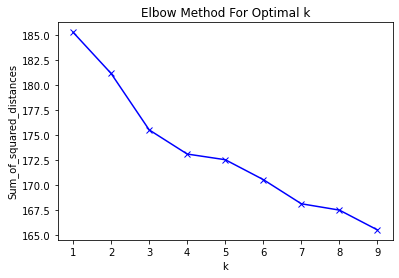

In [16]:
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
#Kmeans
from sklearn.cluster import KMeans
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
description_vectors_tfidf = tfidf_vectorizer.fit_transform(df["clean_description"])

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=4) 
    km = km.fit(description_vectors_tfidf)
    Sum_of_squared_distances.append(km.inertia_)
    

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [17]:
k=3
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=4)
model.fit(description_vectors_tfidf)

KMeans(max_iter=100, n_clusters=3, n_init=1, random_state=4)

In [18]:
df['text_cluster'] = model.labels_


print("cluster centroids:")
print("----------------------")
centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(k):
    print("Cluster ", i)
    print("----------------------")
    for j in centroids[i, :10]:
        print(terms[j])
    print("----------------------")
#for github data
# 0=vehicle projects, 1 = educational projects, 2=robotics projects 

for i in range(0,len(df['text_cluster'])):
    if df['text_cluster'][i]==0:
        df['text_cluster'][i] = "automotive project" 
    elif i==1:
        df['text_cluster'][i] = "educational project"
    else:
        df['text_cluster'][i] = "robotics project"
#df.head()
df.to_csv("cluster_groups_gihub.csv")

cluster centroids:
----------------------
Cluster  0
----------------------
implementation
flight
contains
arduino
vehicle
integration
manipulator
generation
dynamic
processing
----------------------
Cluster  1
----------------------
course
elec
laboratory
robot
repo
milano
mathworks
note
external
falsification
----------------------
Cluster  2
----------------------
robot
scara
modelrob
raspberry
kiwi
ancient
quaternion
syncro
struct
modelisation
----------------------


<ipython-input-18-e6260b19947e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_cluster'][i] = "automotive project"
C:\Users\katuk\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-18-e6260b19947e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_cluster'][i] = "robotics project"


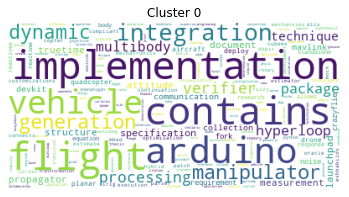

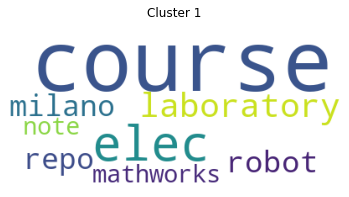

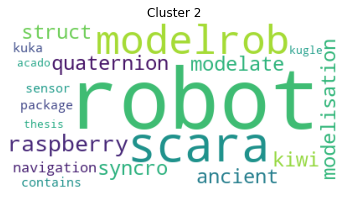

In [19]:
from wordcloud import WordCloud
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        
tf_idf = pd.DataFrame(data = description_vectors_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
final_df = tf_idf
centroids = pd.DataFrame(model.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)


In [20]:
#Tf-Idf_matlab
df_matlab["category"] = df_matlab["category"].replace(np.nan,"",regex=True)
df_matlab["Description"] = df_matlab["summary"].astype(str).str.cat(df_matlab["content"]).astype(str).str.cat(df_matlab["category"])
#print(df_matlab["Description"])
df_matlab["Description"] = df_matlab["Description"].values.astype("U")
for i in range(len(df_matlab["Description"])):
    if(type(df_matlab["Description"][i])!=str):
        df_matlab["Description"][i] = str(df_matlab["Description"][i])
        df_matlab["Description"][i] = ""
        #print(type(i))
df_matlab["clean_description"] = df_matlab["Description"].apply(lambda x: finalpreprocess(x))
# Word2Vec runs on tokenized sentences
df_matlab["clean_description_tokens"] = [applyStemming(nltk.word_tokenize(i), param_stemmer) for i in df_matlab["clean_description"]] 


tfidf_matlab_vectorizer = TfidfVectorizer(use_idf=True)
description_vectors_tfidf_matlab = tfidf_matlab_vectorizer.fit_transform(df_matlab["clean_description"])

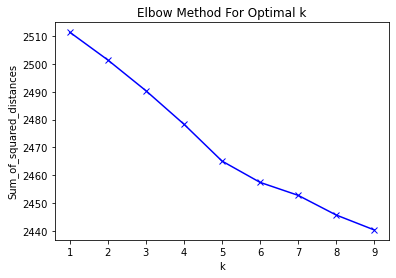

In [21]:
Sum_of_squared_distances = []
K1 = range(1,10)
for k in K1:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=1624)
    km = km.fit(description_vectors_tfidf_matlab)
    Sum_of_squared_distances.append(km.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
k1=4 
model1 = KMeans(n_clusters=k1, init='k-means++', max_iter=100, n_init=1, random_state=1624)
model1.fit(description_vectors_tfidf_matlab)

df_matlab['text_cluster'] = model1.labels_

df_matlab.head()

print("cluster centroids:")
print("----------------------")
centroids = model1.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_matlab_vectorizer.get_feature_names()

for i in range(k1):
    print("Cluster ", i)
    print("----------------------")
    for j in centroids[i, :10]:
        print(terms[j])
    print("----------------------")
#for matlab data;
#0 = energy projects, 1= vehicle projects, 2=network/internet projects,  3=robotics projects
for i in range(0,len(df_matlab['text_cluster'])):
    if df_matlab['text_cluster'][i]==0:
        df['text_cluster'][i] = "energy projects" 
    elif i==1:
        df_matlab['text_cluster'][i] = "vehicle project"
    elif i==2:
        df_matlab['text_cluster'][i] = "network/internet projects"
    else:
        df_matlab['text_cluster'][i] = "robotics project"
df_matlab.to_csv("cluster_groups_matlab.csv")

cluster centroids:
----------------------
Cluster  0
----------------------
cell
energy
series
wind
transmission
turbine
response
fuel
cycle
management
----------------------
Cluster  1
----------------------
vehicle
dynamic
velocity
animation
video
submission
engine
mathworks
wheel
bicycle
----------------------
Cluster  2
----------------------
reference
technique
pulse
change
equation
network
generation
machine
angle
performance
----------------------
Cluster  3
----------------------
arduino
mathworks
sensor
robot
fileexchange
multibody
image
hardware
video
package
----------------------


<ipython-input-22-79b3e9bce077>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matlab['text_cluster'][i] = "robotics project"
C:\Users\katuk\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-22-79b3e9bce077>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matlab['text_cluster'][i] = "vehicle project"
<ipython-input-

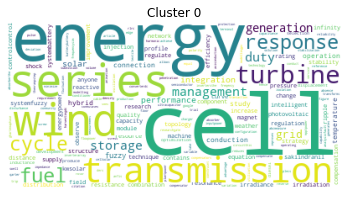

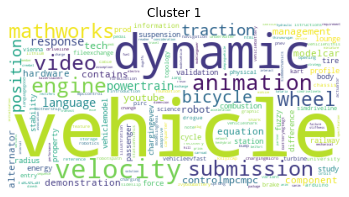

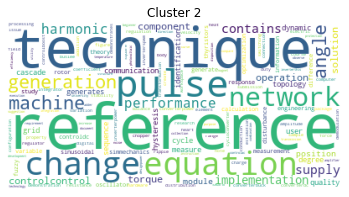

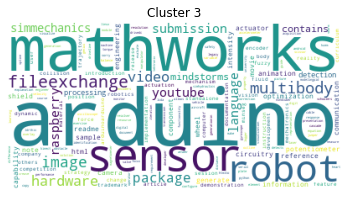

In [23]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        
tf_idf_matlab = pd.DataFrame(data = description_vectors_tfidf_matlab.toarray(), columns=tfidf_matlab_vectorizer.get_feature_names())
final_df_matlab = tf_idf_matlab
centroids1 = pd.DataFrame(model1.cluster_centers_)
centroids1.columns = final_df_matlab.columns
generateWordClouds(centroids1)

In [24]:
# reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
#Word2Vec model
import gensim
from gensim.models import Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

model = Word2Vec(df_matlab['clean_description_tokens'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  
modelw = MeanEmbeddingVectorizer(w2v)
description_vectors_w2v = modelw.transform(df_matlab["clean_description_tokens"])
#print(df['clean_description_tokens'], "\n",[len(word) for word in df['clean_description_tokens']])

# Inspired from https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
# Create a list of strings, one for each description
desc_list = [desc for desc in df_matlab["Description"]]
# Collapse the list of strings into a single long string for processing
big_desc_string = ''.join(desc_list)
# Tokenize the string into words
tokens = word_tokenize(big_desc_string)
# Remove non-alphabetic tokens, such as punctuation, remove stop words and 
words = [word.lower() for word in tokens]
words = [stopword(lemmatizer(stopword(word))) for word in words]
vector_list = [model[word] for word in words if word in model.wv.vocab]
#print(vector_list)
# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab]
print("no of words filtered: ", len(words_filtered))
print("words filtered: ", words_filtered)
# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)
#print(word_vec_zip)
# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df1 = pd.DataFrame.from_dict(word_vec_dict)

<ipython-input-24-462728296c8a>:22: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v = dict(zip(model.wv.index2word, model.wv.syn0))
<ipython-input-24-462728296c8a>:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_list = [model[word] for word in words if word in model.wv.vocab]


no of words filtered:  8841
words filtered:  ['smxl', 'smxl', 'trimmod', 'equilibrium', 'trimmod', 'equilibrium', 'argument', 'trimmod', 'user', 'user', 'trimmod', 'dialog', 'microsoft', 'bluetooth', 'wireless', 'gfsk', 'note', 'bluetooth', 'network', 'wireless', 'bluetooth', 'network', 'wireless', 'bluetooth', 'wireless', 'bluetooth', 'bandpass', 'soundcard', 'audio', 'spectrogram', 'digit', 'note', 'cdma', 'cdma', 'traffic', 'traffic', 'station', 'cdma', 'traffic', 'wireless', 'cdma', 'cdma', 'phone', 'phone', 'phone', 'station', 'phone', 'phone', 'seminar', 'wireless', 'phone', 'speech', 'gfsk', 'bluetooth', 'bluetooth', 'bluetooth', 'network', 'network', 'network', 'virginia', 'mario', 'perugia', 'nasa', 'grant', 'network', 'network', 'perceptron', 'radial', 'cell', 'network', 'functionsalso', 'scalar', 'grbf', 'network', 'network', 'network', 'network', 'network', 'network', 'wavelet', 'wavelet', 'transform', 'wavelet', 'wavelet', 'shark', 'fluid', 'straight', 'cross', 'phenomenon

In [25]:
model1 = Word2Vec(df['clean_description_tokens'],min_count=1)
w2v1 = dict(zip(model.wv.index2word, model1.wv.syn0))  
modelw1 = MeanEmbeddingVectorizer(w2v1)
description_vectors_w2v1 = modelw1.transform(df["clean_description_tokens"])
#print(df['clean_description_tokens'], "\n",[len(word) for word in df['clean_description_tokens']])
desc_list1 = [desc for desc in df["Description"]]
# Collapse the list of strings into a single long string for processing
big_desc_string1 = ''.join(desc_list1)
# Tokenize the string into words
tokens1= word_tokenize(big_desc_string1)
# Remove non-alphabetic tokens, such as punctuation, remove stop words and 
words1 = [word1.lower() for word1 in tokens1]
words1 = [stopword(lemmatizer(stopword(word1))) for word1 in words1]
vector_list1 = [model[word1] for word1 in words1 if word1 in model.wv.vocab]
#print(vector_list)
# Create a list of the words corresponding to these vectors
words_filtered1 = [word1 for word1 in words1 if word1 in model.wv.vocab]
print("no of words filtered: ", len(words_filtered1))
print("words filtered: ", words_filtered1)

<ipython-input-25-6b8323cf3a5d>:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v1 = dict(zip(model.wv.index2word, model1.wv.syn0))


no of words filtered:  103
words filtered:  ['joystick', 'radio', 'usrp', 'research', 'nasa', 'aircraft', 'compressor', 'inlet', 'robot', 'robot', 'robot', 'treatment', 'logger', 'robot', 'document', 'document', 'deploy', 'drone', 'sensor', 'document', 'render', 'research', 'aircraft', 'robot', 'drone', 'connector', 'interact', 'cortex', 'held', 'robot', 'plugin', 'planar', 'kinect', 'robot', 'robot', 'sensor', 'silicon', 'hybrid', 'hybrid', 'hybrid', 'hybrid', 'hybrid', 'wireless', 'flight', 'style', 'orbit', 'flight', 'autopilot', 'proof', 'sensor', 'modelsa', 'pilot', 'arduino', 'toolchain', 'node', 'ethernet', 'linux', 'househeat', 'rail', 'fork', 'robot', 'struct', 'arduino', 'wind', 'steam', 'hydro', 'grid', 'steam', 'hydro', 'inertia', 'excess', 'thermal', 'thermal', 'heat', 'heat', 'planar', 'toolset', 'thermal', 'tesla', 'robot', 'linux', 'hybrid', 'robot', 'robot', 'robot', 'robot', 'quaternion', 'quaternion', 'flight', 'encuentran', 'perceptron', 'arduino', 'attractor', 'buf

<ipython-input-25-6b8323cf3a5d>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_list1 = [model[word1] for word1 in words1 if word1 in model.wv.vocab]


In [6]:
import pandas as pd
df_github_block_info = pd.read_csv("GitHub_Block_Info.csv")
df_github_block_info.head()

,M_ID,File_ID,Model_Name,file_path,BLK_TYPE,Count
0,1,100042416,BlankCntrlr_model.mdl,workdirtmp\DISCON_Simulink-master\Simulink_32b...,Inport,24
1,2,100042416,BlankCntrlr_model.mdl,workdirtmp\DISCON_Simulink-master\Simulink_32b...,SubSystem,1
2,3,100042416,BlankCntrlr_model.mdl,workdirtmp\DISCON_Simulink-master\Simulink_32b...,Outport,8
3,4,100042416,BlankCntrlr_model.mdl,workdirtmp\DISCON_Simulink-master\Simulink_32b...,Constant,4
4,5,100042416,BlankCntrlr_model.mdl,workdirtmp\DISCON_Simulink-master\Simulink_32b...,Mux,1


In [9]:
df_github_block_info_count = df_github_block_info[['File_ID', 'Count']]
df_github_block_info_count.head()

,File_ID,Count
0,100042416,24
1,100042416,1
2,100042416,8
3,100042416,4
4,100042416,1


In [26]:
# # reference: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb


# def run_KMeans(max_k, data):
#     max_k += 1
#     kmeans_results = dict()
#     for k in range(2 , max_k):
#         kmeans = cluster.KMeans(n_clusters = k
#                                , init = 'k-means++'
#                                , n_init = 1
#                                , tol = 0.001
#                                , max_iter = 100
#                                , random_state = 1
#                                , algorithm = 'full')

#         kmeans_results.update( {k : kmeans.fit(data)} )
        
#     return kmeans_results

In [27]:
# import matplotlib.cm as cm
# def printAvg(avg_dict):
#     for avg in sorted(avg_dict.keys(), reverse=True):
#         print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
# def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
#     fig, ax1 = plt.subplots(1)
#     fig.set_size_inches(8, 6)
#     ax1.set_xlim([-0.2, 1])
#     ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
#     plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
#     y_lower = 10
#     sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
#         y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
#     plt.show()
    
# sil_scores = []
# def silhouette(kmeans_dict, df, plot=False):
#     df = df.to_numpy()
#     avg_dict = dict()
#     for n_clusters, kmeans in kmeans_dict.items():      
#         kmeans_labels = kmeans.predict(df)
#         silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
#         sil_scores.append(silhouette_avg)
#         avg_dict.update( {silhouette_avg : n_clusters} )
#         print("average silhouette score",silhouette_avg, "for k =", n_clusters)
#         if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)


In [28]:
# Sum_of_squared_distances = []
# K = range(1,20)
# for k in K:
#     km = KMeans(n_clusters=best_result, init='k-means++', max_iter=100, n_init=1, random_state=3425)
#     km = km.fit(description_vectors_tfidf)
#     Sum_of_squared_distances.append(km.inertia_)
    
# import matplotlib.pyplot as plt
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [29]:
# # Running Kmeans
# k = 12
# kmeans_results = run_KMeans(k, final_df)

# # Plotting Silhouette Analysis
# silhouette(kmeans_results, final_df, plot=True)

In [30]:
# x=[]
# for i in range(2, k+1):
#     x.append(i)
# y = sil_scores
# plt.plot(x,y)
# plt.title('silhouette vs K')
# plt.xlabel('K')
# plt.ylabel('silhouette score')
# plt.show()
# sil_scores.clear()

In [31]:
# def get_top_features_cluster(tf_idf_array, prediction, n_feats):
#     labels = np.unique(prediction)
#     dfs = []
#     for label in labels:
#         id_temp = np.where(prediction==label) # indices for each cluster
#         x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
#         sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
#         features = tfidf_vectorizer.get_feature_names()
#         best_features = [(features[i], x_means[i]) for i in sorted_means]
#         df = pd.DataFrame(best_features, columns = ['features', 'score'])
#         dfs.append(df)
#     return dfs

# def plotWords(dfs, n_feats):
#     plt.figure(figsize=(8, 4))
#     for i in range(0, len(dfs)):
#         plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
#         sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
#         plt.show()

In [32]:
# best_result = 5
# model = KMeans(n_clusters=best_result, init='k-means++', max_iter=100, n_init=1)
# kmeans = model.fit(description_vectors_tfidf)

# # kmeans = kmeans_results.get(best_result)
# final_df_array = final_df.to_numpy()
# prediction = kmeans.predict(final_df)
# n_feats = 5
# dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
# plotWords(dfs, 13)


In [33]:
# df['desc_cluster_labels'] = prediction
# #df.head()

In [34]:
# from wordcloud import WordCloud
# # Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
# def centroidsDict(centroids, index):
#     a = centroids.T[index].sort_values(ascending = False).reset_index().values
#     centroid_dict = dict()

#     for i in range(0, len(a)):
#         centroid_dict.update( {a[i,0] : a[i,1]} )

#     return centroid_dict

# def generateWordClouds(centroids):
#     wordcloud = WordCloud(max_font_size=100, background_color = 'white')
#     for i in range(0, len(centroids)):
#         centroid_dict = centroidsDict(centroids, i)        
#         wordcloud.generate_from_frequencies(centroid_dict)

#         plt.figure()
#         plt.title('Cluster {}'.format(i))
#         plt.imshow(wordcloud)
#         plt.axis("off")
#         plt.show()
        

# centroids = pd.DataFrame(kmeans.cluster_centers_)
# centroids.columns = final_df.columns
# generateWordClouds(centroids)

In [35]:
# tfidf for matlab data (df_matlab)

In [36]:
# #Tf-Idf_matlab
# df_matlab["category"] = df_matlab["category"].replace(np.nan,"",regex=True)
# df_matlab["Description"] = df_matlab["summary"].astype(str).str.cat(df_matlab["content"]).astype(str).str.cat(df_matlab["category"])
# #print(df_matlab["Description"])



In [37]:
# for i in range(len(df_matlab["Description"])):
#     if(type(df_matlab["Description"][i])!=str):
#         df_matlab["Description"][i] = str(df_matlab["Description"][i])
#         df_matlab["Description"][i] = ""
#         #print(type(i))
# df_matlab["clean_description"] = df_matlab["Description"].apply(lambda x: finalpreprocess(x))

In [38]:
# # Word2Vec runs on tokenized sentences
# df_matlab["clean_description_tokens"] = [applyStemming(nltk.word_tokenize(i), param_stemmer) for i in df_matlab["clean_description"]] 
# #print(df_matlab["clean_description"])
# #print(df_matlab["clean_description_tokens"])

In [39]:
# tfidf_matlab_vectorizer = TfidfVectorizer(use_idf=True)
# description_vectors_tfidf_matlab = tfidf_matlab_vectorizer.fit_transform(df_matlab["clean_description"])
# data1 = description_vectors_tfidf_matlab.toarray()
# tf_idf_matlab = pd.DataFrame(data = data1 , columns=tfidf_matlab_vectorizer.get_feature_names())

# final_df_matlab = tf_idf_matlab

# print("{} rows".format(final_df_matlab.shape))
# #final_df.T.nlargest(5, 0) 

In [40]:
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(description_vectors_tfidf_matlab)
#     Sum_of_squared_distances.append(km.inertia_)
    
# import matplotlib.pyplot as plt
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [41]:
# # reference: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

# def run_KMeans(max_k, data1):
#     max_k += 1
#     kmeans_results1 = dict()
#     for k in range(2 , max_k):
#         kmeans = cluster.KMeans(n_clusters = k
#                                , init = 'k-means++'
#                                , n_init = 10
#                                , tol = 0.001
#                                , random_state = 1
#                                , algorithm = 'full')

#         kmeans_results1.update( {k : kmeans.fit(data1)} )
        
#     return kmeans_results1

In [42]:
# def printAvg(avg_dict):
#     for avg in sorted(avg_dict.keys(), reverse=True):
#         print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
# def plotSilhouette(df_matlab, n_clusters, kmeans_labels1, silhouette_avg):
#     fig, ax1 = plt.subplots(1)
#     fig.set_size_inches(8, 6)
#     ax1.set_xlim([-0.2, 1])
#     ax1.set_ylim([0, len(df_matlab) + (n_clusters + 1) * 10])
    
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
#     plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
#     y_lower = 10
#     sample_silhouette_values1 = silhouette_samples(df_matlab, kmeans_labels1) # Compute the silhouette scores for each sample
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values1[kmeans_labels1 == i]
#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
#         y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
#     plt.show()
# sil_scores1 = []
# def silhouette(kmeans_dict, df_matlab, plot=False):
#     df_matlab = df_matlab.to_numpy()
#     avg_dict = dict()
#     for n_clusters, kmeans in kmeans_dict.items():      
#         kmeans_labels1 = kmeans.predict(df_matlab)
#         silhouette_avg1 = silhouette_score(df_matlab, kmeans_labels1) # Average Score for all Samples
#         sil_scores1.append(silhouette_avg1)
#         avg_dict.update( {silhouette_avg1 : n_clusters} )
#         print("average silhouette score",silhouette_avg1, "for k =", n_clusters)
#         if(plot): plotSilhouette(df_matlab, n_clusters, kmeans_labels1, silhouette_avg1)

In [43]:
# # Running Kmeans
# k1 = 10
# kmeans_results1 = run_KMeans(k1, final_df_matlab)

# # Plotting Silhouette Analysis
# silhouette(kmeans_results1, final_df_matlab, plot=True)

In [44]:
# x1=[]
# for i in range(2, k1+1):
#     x1.append(i)
# y1 = sil_scores1
# plt.plot(x1,y1)
# plt.title('silhouette vs K')
# plt.xlabel('K')
# plt.ylabel('silhouette score')
# plt.show()
# sil_scores.clear()

In [45]:
# def get_top_features_cluster(tf_idf_matlab_array, prediction1, n_feats):
#     labels = np.unique(prediction1)
#     df_matlabs = []
#     for label in labels:
#         id_temp = np.where(prediction1==label) # indices for each cluster
#         x_means = np.mean(tf_idf_matlab_array[id_temp], axis = 0) # returns average score across cluster
#         sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
#         features = tfidf_matlab_vectorizer.get_feature_names()
#         best_features = [(features[i], x_means[i]) for i in sorted_means]
#         df_matlab = pd.DataFrame(best_features, columns = ['features', 'score'])
#         df_matlabs.append(df_matlab)
#     return df_matlabs

# def plotWords(df_matlabs, n_feats):
#     plt.figure(figsize=(8, 4))
#     for i in range(0, len(df_matlabs)):
#         plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
#         sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_matlabs[i][:n_feats])
#         plt.show()

In [46]:
# best_result1 = 5 #7

# kmeans = kmeans_results1.get(best_result1)
# #kmeans = model.fit(description_vectors_tfidf_matlab)
# final_df_matlab_array = final_df_matlab.to_numpy()
# prediction1 = kmeans.predict(final_df_matlab)
# n_feats1 = 10
# df_matlabs = get_top_features_cluster(final_df_matlab_array, prediction1, n_feats1)
# plotWords(df_matlabs, 13)


In [47]:
# df_matlab['desc_cluster_labels'] = prediction1

In [48]:
# from wordcloud import WordCloud
# # Transforms a centroids1 dataframe into a dictionary to be used on a WordCloud.
# def centroids1Dict(centroids1, index):
#     a = centroids1.T[index].sort_values(ascending = False).reset_index().values
#     centroid_dict = dict()

#     for i in range(0, len(a)):
#         centroid_dict.update( {a[i,0] : a[i,1]} )

#     return centroid_dict

# def generateWordClouds(centroids1):
#     wordcloud = WordCloud(max_font_size=100, background_color = 'white')
#     for i in range(0, len(centroids1)):
#         centroid_dict = centroids1Dict(centroids1, i)        
#         wordcloud.generate_from_frequencies(centroid_dict)

#         plt.figure()
#         plt.title('Cluster {}'.format(i))
#         plt.imshow(wordcloud)
#         plt.axis("off")
#         plt.show()

In [49]:
# centroids1 = pd.DataFrame(kmeans.cluster_centers_)
# centroids1.columns = final_df_matlab.columns
# generateWordClouds(centroids1)

In [50]:

# # reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
# #Word2Vec model
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(next(iter(word2vec.values())))
#     def fit(self, X, y):
#         return self
#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

In [51]:
# # reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
# model = Word2Vec(df_matlab['clean_description_tokens'],min_count=1)
# w2v = dict(zip(model.wv.index2word, model.wv.syn0))  
# modelw = MeanEmbeddingVectorizer(w2v)
# description_vectors_w2v = modelw.transform(df_matlab["clean_description_tokens"])
# #print(df['clean_description_tokens'], "\n",[len(word) for word in df['clean_description_tokens']])


In [52]:
# print("df shape: ",df.shape)
# print("df type: ", type(df))

# print("description_vectors_w2v shape: ", description_vectors_w2v.shape)
# print("description_vectors_w2v type:", type(description_vectors_w2v))
# #df.to_csv("df.csv")
# #print("description_vectors_w2v values:")
# #print(description_vectors_w2v)

In [53]:
# X = description_vectors_w2v1
# inertia = []
# K = range(1,10)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=1234)
#     kmeanModel.fit(X)
#     inertia.append(kmeanModel.inertia_)
# plt.plot(K, inertia, 'bx-')
# plt.title('Elbow Method')
# plt.xlabel('number of clusters')
# plt.ylabel('Inertia')
# plt.show()
# #elbow at K=4

In [54]:
# n_c = 3
# import random
# # random.seed(1234)
# kmc = KMeans(n_clusters = n_c, max_iter = 100, init='k-means++', n_init=1, random_state=1234)
# labels = kmc.fit_predict(X)
# print(labels)
# print(len(labels))
# # for index, desc in enumerate(df['clean_description_tokens']):
# #     print(str(labels[index]) + ":" + str(desc))
# df["desc_cluster_labels"] = labels
# #df.head()

In [55]:
# pca = PCA(n_components = 2).fit(X)
# coordinates = pca.transform(X)
# label_colors = [ "#A2DAD2", "#A2B5DA", "#DAA2C6", "#B0ABAB"]
# colors = [label_colors[i] for i in labels]
# plt.scatter(coordinates[:,0], coordinates[:,1], c=colors)
# centroids = kmc.cluster_centers_
# centroid_coordinates = pca.transform(centroids)
# plt.scatter(centroid_coordinates[:,0], centroid_coordinates[:,1], marker='X', s=70)
# plt.show()

In [56]:
# # Inspired from https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
# # Create a list of strings, one for each description
# desc_list = [desc for desc in df_matlab["Description"]]
# # Collapse the list of strings into a single long string for processing
# big_desc_string = ''.join(desc_list)
# # Tokenize the string into words
# tokens = word_tokenize(big_desc_string)
# # Remove non-alphabetic tokens, such as punctuation, remove stop words and 
# words = [word.lower() for word in tokens]
# words = [stopword(lemmatizer(stopword(word))) for word in words]
# vector_list = [model[word] for word in words if word in model.wv.vocab]


# # Create a list of the words corresponding to these vectors
# words_filtered = [word for word in words if word in model.wv.vocab]
# print("no of words filtered: ", len(words_filtered))
# print("words filtered: ", words_filtered)
# # Zip the words together with their vector representations
# word_vec_zip = zip(words_filtered, vector_list)
# #print(word_vec_zip)
# # Cast to a dict so we can turn it into a DataFrame
# word_vec_dict = dict(word_vec_zip)

# df1 = pd.DataFrame.from_dict(word_vec_dict)


In [57]:
#print(model)

#print(df1.head())
# #type(df1)
# df.reset_index(drop=True, inplace=True)
# df1.reset_index(drop=True, inplace=True)
#print(df1.describe())
#print(df1.head())
#print(df.head())
#concatenating the original dataframe and the features dataframe to try clustering based on all the features but using all the features is not desirable so commenting out
#df2 = pd.concat([df,df1], axis=1)
#print(df1.head())
#print(list(model.wv.vocab))



In [58]:
# print(vector_list[1])

In [59]:
# # reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
# model1 = Word2Vec(df['clean_description_tokens'],min_count=1)
# w2v1 = dict(zip(model.wv.index2word, model1.wv.syn0))  
# modelw1 = MeanEmbeddingVectorizer(w2v1)
# description_vectors_w2v1 = modelw1.transform(df["clean_description_tokens"])
# #print(df['clean_description_tokens'], "\n",[len(word) for word in df['clean_description_tokens']])
# desc_list1 = [desc for desc in df["Description"]]
# # Collapse the list of strings into a single long string for processing
# big_desc_string1 = ''.join(desc_list1)
# # Tokenize the string into words
# tokens1= word_tokenize(big_desc_string1)
# # Remove non-alphabetic tokens, such as punctuation, remove stop words and 
# words1 = [word1.lower() for word1 in tokens1]
# words1 = [stopword(lemmatizer(stopword(word1))) for word1 in words1]
# vector_list1 = [model[word1] for word1 in words1 if word1 in model.wv.vocab]
# #print(vector_list)
# # Create a list of the words corresponding to these vectors
# words_filtered1 = [word1 for word1 in words1 if word1 in model.wv.vocab]
# print("no of words filtered: ", len(words_filtered1))
# print("words filtered: ", words_filtered1)

In [60]:
# # Initialize t-SNE
# tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# tsne_df = tsne.fit_transform(df1)

In [61]:
# print(tsne_df.shape)
# tsne_df = pd.DataFrame(tsne_df, columns = ['desc_num_1', 'desc_num_2'])
# tsne_df = tsne_df.astype(np.float).applymap('{:,.4f}'.format)
# #print(tsne_df.dtypes)
# replaceinf = tsne_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# dropna = tsne_df.fillna(tsne_df.mean())
# #print(dropna, replaceinf)
# #print(tsne_df)
# #to find if any infinite values or nan values
# #print(np.any(np.isnan(tsne_df)))
# #print(np.all(np.isfinite(tsne_df)))
# #print(tsne_df.head())
# #concatenating the original dataframe and the dimension reduced features dataframe 
# df_tsne_df1 = pd.concat([tsne_df,df], axis=1)
# #print(df_tsne_df1.head())
# tsne_df.head()

In [62]:
# #removing all columns except for the numeric columns (converted and original)
# df3 = df_tsne_df1.drop(["numeric_cluster","clean_description_tokens","clean_description","Description","id","repo_name", "owner_name",  "is_private", "project_url", "is_forked", "api_url", "created_at", "updated_at", "pushed_at"
# , "homepage_url", "size_in_kb", "language", "open_issues_count", "master_branch", "default_branch", "Topics", "license", "model_files", "version_sha"
# ], axis = 1)
# df3.head()

In [63]:
# scaler = preprocessing.MinMaxScaler()
# features_normal1 = scaler.fit_transform(df1)
# inertia = []
# K = range(1,30)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(features_normal1)
#     kmeanModel.fit(features_normal)
#     inertia.append(kmeanModel.inertia_)
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Inertia')
# plt.show()

In [64]:
# sns.set()
# # Initialize figure
# fig, ax = plt.subplots(figsize = (11.7, 8.27))
# sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# # Import adjustText, initialize list of texts
# #use this "conda install -c conda-forge adjusttext" or pip install adjusttext

# texts = []
# words_to_plot = list(np.arange(0, 100, 10))

# # Append words to list
# for word in words_to_plot:
#     texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df1.index[word], fontsize = 14))
# print(texts)
# # Plot text using adjust_text (because overlapping text is hard to read)
# adjust_text(texts, force_points = 0.4, force_text = 0.4, 
#             expand_points = (2,1), expand_text = (1,2),
#             arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

# plt.show()

In [65]:
# #reference for mbkmeans from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/

# def mbkmeans_clusters(
# 	X, 
#     k, 
#     mb, 
#     print_silhouette_values, 
# ):
#     """Generate clusters and print Silhouette metrics using MBKmeans

#     Args:
#         X: Matrix of features.
#         k: Number of clusters.
#         mb: Size of mini-batches.
#         print_silhouette_values: Print silhouette values per cluster.

#     Returns:
#         Trained clustering model and labels based on X.
#     """
#     km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
#     print(f"For n_clusters = {k}")
#     print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.4f}")
#     print(f"Inertia:{km.inertia_}")

#     if print_silhouette_values:
#         sample_silhouette_values = silhouette_samples(X, km.labels_)
#         print(f"Silhouette values:")
#         silhouette_values = []
#         for i in range(k):
#             cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
#             silhouette_values.append(
#                 (
#                     i,
#                     cluster_silhouette_values.shape[0],
#                     cluster_silhouette_values.mean(),
#                     cluster_silhouette_values.min(),
#                     cluster_silhouette_values.max(),
#                 )
#             )
#         silhouette_values = sorted(
#             silhouette_values, key=lambda tup: tup[2], reverse=True
#         )
#         for s in silhouette_values:
#             print(
#                 f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
#             )
#     return km, km.labels_


In [66]:
# #print(description_vectors_w2v)
# clustering, cluster_labels = mbkmeans_clusters(
# 	X=description_vectors_w2v,
#     k=5,
#     mb=400,
#     print_silhouette_values=True,
# )

In [67]:
# df_clusters = pd.DataFrame({
#     "text": df['clean_description_tokens'],
#     "tokens": [" ".join(text) for text in df['clean_description_tokens']],
#     "cluster": cluster_labels
# })

In [68]:
# print("Most representative terms per cluster (based on centroids):")
# for i in range(5):
#     tokens_per_cluster = ""
#     most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=3)
#     for t in most_representative:
#         tokens_per_cluster += f"{t[0]} "
#     print(f"Cluster {i}: {tokens_per_cluster}")

In [69]:
# from gensim import corpora
# import pickle
# dictionary = corpora.Dictionary(df["clean_description_tokens"]) 
# corpus = [dictionary.doc2bow(text) for text in df["clean_description_tokens"]]
# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim')
# NUM_TOPICS = 3
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [70]:
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
# ldamodel.save('model3.gensim')
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [71]:
# dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
# corpus = pickle.load(open('corpus.pkl', 'rb'))
# lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
# import pyLDAvis.gensim_models #conda install -c conda-forge pyLDAvis.gensim
# lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)